# 1. Overview

# 2. Import Necessary Libraries

In [1]:
# pip install keras_tuner

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# 3. Define Global Variables

In [3]:
input_X_train_path = 'data/train_processed.csv'
input_X_test_path = 'data/test_processed.csv'

# 4. Functions

In [4]:
def plot_confusion_matrix_and_f1(y_test, y_pred, title='Confusion Matrix'):
    """
    This function plots a confusion matrix and calculates the F1 score.

    Parameters:
    y_test (array-like): True labels
    y_pred (array-like): Predicted labels
    title (str): Title for the confusion matrix plot

    Returns:
    float: The weighted F1 score
    """

    # Predefined labels list
    labels_list = ["Negative emotion", "Positive emotion", "No emotion"]

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

    # Calculate percentages
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    # Combine the count and the percentage into one annotation
    labels = [f"{count}\n{percent:.2f}%" for count, percent in zip(conf_matrix.flatten(), conf_matrix_percent.flatten())]
    labels = np.asarray(labels).reshape(3, 3)

    # Plot the confusion matrix without the color bar
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=labels, fmt="", cmap="Blues", cbar=False, 
                xticklabels=labels_list, 
                yticklabels=labels_list)

    plt.xlabel(r'$\bf{Predicted\ labels}$')
    plt.ylabel(r'$\bf{True\ labels}$')
    plt.title(title)
    plt.show()

    # Calculate and return the F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1:.2f}")

In [5]:
def build_model(hp):
    """
    This function builds a neural network model with tunable hyperparameters.
    
    Input:
    - hp (HyperParameters object): This is the object provided by Keras Tuner, which allows us to define tunable hyperparameters for the model architecture (e.g., number of units, dropout rate, learning rate).
    
    Output:
    - model (Sequential object): A compiled Keras Sequential model with a defined architecture, which includes a tunable number of layers, neurons per layer, dropout rates, and learning rate.
    
    Logic: 
    - The model's architecture (layers, units, dropout) and the optimizer's learning rate are tuned according to the hyperparameters suggested by the tuner.
    """
    
    model = Sequential()  # Initialize the sequential model
    
    # Input Layer + First Hidden Layer
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=32), 
                    activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)))

    # Second Hidden Layer
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=32), 
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.3, max_value=0.5, step=0.1)))

    # Third Hidden Layer
    model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=64, step=16), 
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.3, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(units=3, activation='softmax'))  # Output layer for 3 classes
    
    # Compile the model with a tunable learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [6]:
def build_model_l2(hp):
    """
    This function builds a neural network model with L2 regularization and tunable hyperparameters.
    
    Input:
    - hp (HyperParameters object): A Keras Tuner object that allows us to define tunable hyperparameters 
      such as the number of units in each layer, dropout rates, and the learning rate.

    Output:
    - model (Sequential object): A compiled Keras Sequential model with a specified architecture,
      including dense layers, L2 regularization, and dropout layers. The model is compiled with
      the Adam optimizer and categorical crossentropy loss for a classification task.

    Logic:
    - The function constructs a model with three dense layers, each followed by a dropout layer.
      The number of units, dropout rate, and learning rate are tunable hyperparameters. 
      The L2 regularization is applied to each dense layer to reduce overfitting. The output layer 
      uses softmax activation for multi-class classification.
    """
    model = tf.keras.Sequential()  # Use tf.keras.Sequential() instead of keras.Sequential
    
    # First layer with L2 regularization and input dimension specified
    model.add(layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.005),
                           input_dim=X_train_np.shape[1]))  # input_dim added here
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    # Second layer with L2 regularization
    model.add(layers.Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.005)))  # L2 regularization added here
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    # Third layer with L2 regularization
    model.add(layers.Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.005)))  # L2 regularization added here
    model.add(layers.Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer (assuming a classification task)
    model.add(layers.Dense(3, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [7]:
def build_model_l1(hp):
    """
    This function builds a neural network model with L1 regularization and tunable hyperparameters.
    
    Input:
    - hp (HyperParameters object): A Keras Tuner object that allows us to define tunable hyperparameters 
      such as the number of units in each layer, dropout rates, and the learning rate.

    Output:
    - model (Sequential object): A compiled Keras Sequential model with a specified architecture,
      including dense layers, L1 regularization, and dropout layers. The model is compiled with
      the Adam optimizer and categorical crossentropy loss for a classification task.

    Logic:
    - The function constructs a model with three dense layers, each followed by a dropout layer.
      The number of units, dropout rate, and learning rate are tunable hyperparameters. 
      L1 regularization is applied to each dense layer to enforce sparsity in the weights and reduce overfitting.
      The output layer uses softmax activation for multi-class classification.
    """       
    model = tf.keras.Sequential()  # Use tf.keras.Sequential() instead of keras.Sequential
    
    # First layer with L1 regularization and input dimension specified
    model.add(layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                           activation='relu',
                           kernel_regularizer=regularizers.l1(0.005),  # L1 regularization instead of L2
                           input_dim=X_train_np.shape[1]))  # input_dim added here
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    # Second layer with L1 regularization
    model.add(layers.Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                           activation='relu',
                           kernel_regularizer=regularizers.l1(0.005)))  # L1 regularization added here
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    # Third layer with L1 regularization
    model.add(layers.Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32),
                           activation='relu',
                           kernel_regularizer=regularizers.l1(0.005)))  # L1 regularization added here
    model.add(layers.Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer (assuming a classification task)
    model.add(layers.Dense(3, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
def build_model_es(hp):    
    """
    This function builds a neural network model without regularization and with tunable hyperparameters.
    
    Input:
    - hp (HyperParameters object): A Keras Tuner object that allows us to define tunable hyperparameters 
      such as the number of units in each layer, dropout rates, and the learning rate.

    Output:
    - model (Sequential object): A compiled Keras Sequential model with a specified architecture, 
      including dense layers and dropout layers. The model is compiled with the Adam optimizer and 
      categorical crossentropy loss for a classification task.

    Logic:
    - The function constructs a model with three dense layers, each followed by a dropout layer.
      The number of units, dropout rate, and learning rate are tunable hyperparameters. 
      There is no regularization applied to the layers in this model.
      The output layer uses softmax activation for multi-class classification.
    """
    model = tf.keras.Sequential()  # Use tf.keras.Sequential() instead of keras.Sequential
    
    # First layer without regularization and input dimension specified
    model.add(layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                           activation='relu',
                           input_dim=X_train_np.shape[1]))  # input_dim added here
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    # Second layer without regularization
    model.add(layers.Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                           activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    # Third layer without regularization
    model.add(layers.Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32),
                           activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer (assuming a classification task)
    model.add(layers.Dense(3, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 5. Choosing the metric

Taking into consideration the Business case that was defined in the notebook 01_data_understanding, we are going to use the F1-Score because we consider that there is not a specific type of error more grave than the other. We want to detect negative, positive and neutral emotions and we want to use a model that does the best generalization. 

# 6. Code

We are going to open both csv files from the notebook 02_data_preprocessing

In [9]:
df_train = pd.read_csv(input_X_train_path)
df_test = pd.read_csv(input_X_test_path)

In [10]:
df_train.head()

,aapl,aaron,ab,abandoned,abba,ability,able,abnormal,about,above,...,¼¼,¾ð,á¾,äá,ìù,ðü,öý,emotion_type_encoded,product_mention_Both,product_mention_Google
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.378947,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [11]:
df_test.head()

,aapl,aaron,ab,abandoned,abba,ability,able,abnormal,about,above,...,¼¼,¾ð,á¾,äá,ìù,ðü,öý,emotion_type_encoded,product_mention_Both,product_mention_Google
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0


Let's do the separation between X_train, y_train, X_test, y_test

In [12]:
# For train
X_train, y_train = df_train.drop('emotion_type_encoded', axis=1), df_train['emotion_type_encoded']

# For test
X_test, y_test = df_test.drop('emotion_type_encoded', axis=1), df_test['emotion_type_encoded']

We will now proceed to train different models

## 6.1 Multinomial LR

In [13]:
# Initialize the Multinomial Logistic Regression model
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=12)

# Fit the model on the training data
lr.fit(X_train, y_train)

# Make predictions on the test data
y_pred_test_lr = lr.predict(X_test)

# Make predictions on the training data to check for overfitting
y_pred_train_lr = lr.predict(X_train)

C:\Users\Usuario\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Let's look at the confusion matrix

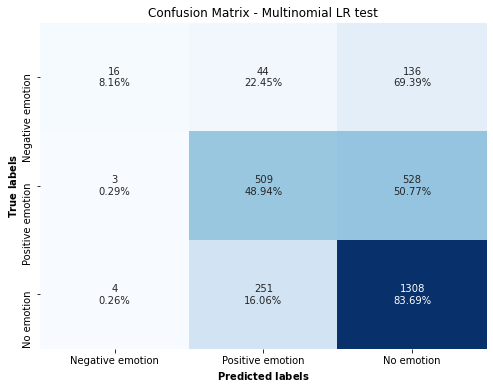

Weighted F1 Score: 0.63


In [14]:
plot_confusion_matrix_and_f1(y_test, y_pred_test_lr, title='Confusion Matrix - Multinomial LR test')

Let's look at the confusion matrix of the train dataset to check for overfitting

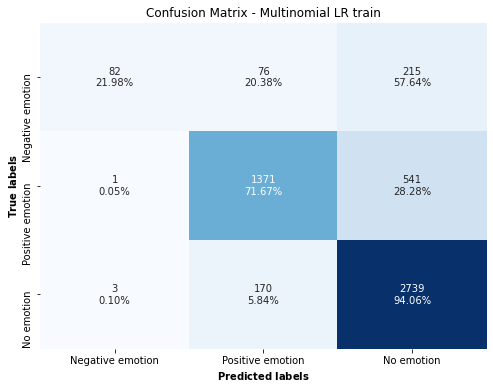

Weighted F1 Score: 0.79


In [15]:
plot_confusion_matrix_and_f1(y_train, y_pred_train_lr, title='Confusion Matrix - Multinomial LR train')

As can be seen. Here the overfitting is very low when we look at the different F1-Scores of the test and train dataset.

## 6.2 Random Forest

In [16]:
# Initializing the RandomForestClassifier
rf = RandomForestClassifier(random_state=12)

# Let's do a fit on X_train and y_train
rf.fit(X_train, y_train)

# Let's do the predict of X_test
y_pred_test_rf = rf.predict(X_test)

Given that we have a multiclass problem, we are going to use the f1-score to detect the errors in the most generic way, as said before in section 5. F1-score combines the errors of recall and precision. This metric is good for unbalanced datasets. 

We are going to use the confusion matrix and the f1_score to chose our best model

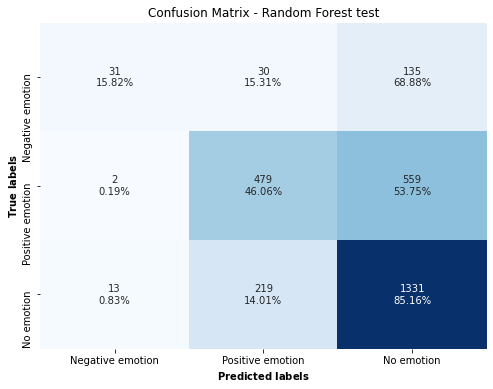

Weighted F1 Score: 0.63


In [17]:
plot_confusion_matrix_and_f1(y_test, y_pred_test_rf, title='Confusion Matrix - Random Forest test')

We are going to check the level of overfitting in the Random Forest Model

In [18]:
# Let's do the predict of X_train
y_pred_train_rf = rf.predict(X_train)

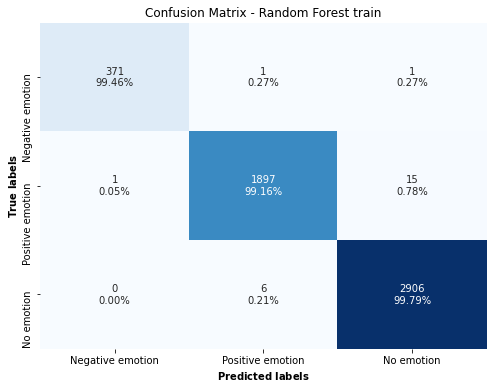

Weighted F1 Score: 1.00


In [19]:
plot_confusion_matrix_and_f1(y_train, y_pred_train_rf, title='Confusion Matrix - Random Forest train')

As we can see, there is a very significant overfitting as the F1 score of the train dataset is 0.99 whereas the F1 score of the test dataset is 0.63

We are now going to do another Random Forest model to try to eliminate the overfitting.

In [20]:
# Initializing the RandomForestClassifier
rf_2 = RandomForestClassifier(n_estimators=100, max_depth=24, random_state=12)

# Let's do a fit on X_train and y_train
rf_2.fit(X_train, y_train)

# Let's do the predict of X_test
y_pred_test_rf_2 = rf_2.predict(X_test)

Let's take a look at the overfitting again

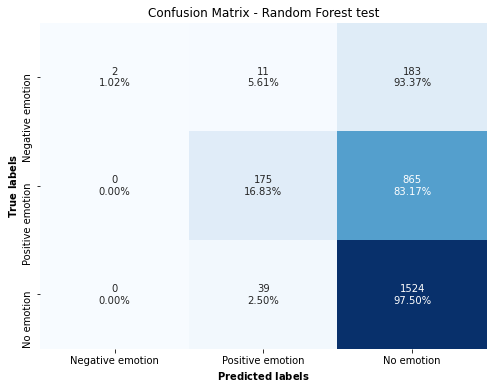

Weighted F1 Score: 0.52


In [21]:
plot_confusion_matrix_and_f1(y_test, y_pred_test_rf_2, title='Confusion Matrix - Random Forest test')

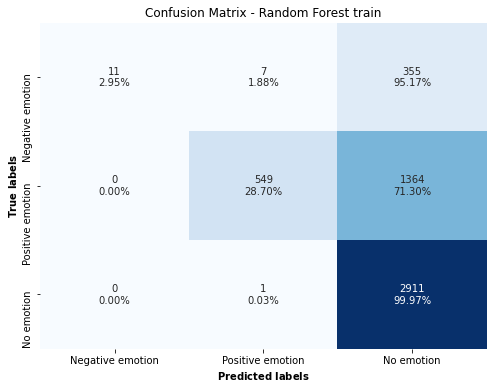

Weighted F1 Score: 0.60


In [22]:
# Let's do the predict of X_train
y_pred_train_rf_2 = rf_2.predict(X_train)
plot_confusion_matrix_and_f1(y_train, y_pred_train_rf_2, title='Confusion Matrix - Random Forest train')

We have been able to mitigate the overfitting, however the results are not satisfactory and so we decide to not use this model from now onwards.

## 6.3 Neural Networks

In [23]:
# Define the neural network model
model = Sequential()

# Adding the input layer and the first hidden layer with dropout
model.add(Dense(units=128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(rate=0.5))  # Dropout with 50% rate

# Adding the second hidden layer with dropout
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.5))  # Dropout with 50% rate

# Adding the third hidden layer with dropout
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.5))  # Dropout with 50% rate

# Adding the output layer
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Training the model

# Convert to NumPy arrays
X_train_np = X_train.to_numpy()  # Convert features to a NumPy array
y_train_np = to_categorical(y_train.to_numpy())  # Convert labels to a one-hot encoded NumPy array

# Doing the same conversion to the test data
X_test_np = X_test.to_numpy()
y_test_np = to_categorical(y_test.to_numpy())

# Doing the fit
model.fit(
    X_train_np,       # Input data (features)
    y_train_np,       # Target data (one-hot encoded labels)
    epochs=10,        # Number of times the model will see the entire dataset
    batch_size=64,    # Number of samples per gradient update
    validation_data=(X_test_np, y_test_np)  # Validation data (optional)
)

Epoch 1/10
82/82 [==============================] - 1s 7ms/step - loss: 0.9419 - accuracy: 0.5237 - val_loss: 0.8584 - val_accuracy: 0.5584
Epoch 2/10
82/82 [==============================] - 1s 7ms/step - loss: 0.8490 - accuracy: 0.5654 - val_loss: 0.8100 - val_accuracy: 0.5827
Epoch 3/10
82/82 [==============================] - 0s 5ms/step - loss: 0.7552 - accuracy: 0.6402 - val_loss: 0.7686 - val_accuracy: 0.6438
Epoch 4/10
82/82 [==============================] - 0s 5ms/step - loss: 0.6207 - accuracy: 0.7437 - val_loss: 0.8042 - val_accuracy: 0.6292
Epoch 5/10
82/82 [==============================] - 0s 5ms/step - loss: 0.5118 - accuracy: 0.8015 - val_loss: 0.8658 - val_accuracy: 0.6427
Epoch 6/10
82/82 [==============================] - 0s 5ms/step - loss: 0.4091 - accuracy: 0.8532 - val_loss: 0.9400 - val_accuracy: 0.6520
Epoch 7/10
82/82 [==============================] - 0s 5ms/step - loss: 0.3570 - accuracy: 0.8740 - val_loss: 0.9955 - val_accuracy: 0.6431
Epoch 8/10
82/82 [==

In [25]:
# Make predictions
predictions = model.predict(X_test_np)

# Since the model outputs probabilities, we want to convert these to class labels
# Find the index of the maximum probability for each sample, which corresponds to the predicted class
predicted_classes = np.argmax(predictions, axis=1)

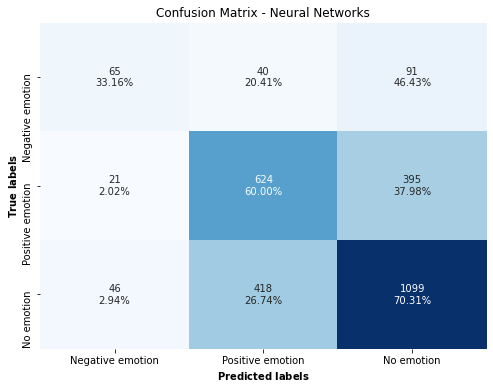

Weighted F1 Score: 0.64


In [26]:
plot_confusion_matrix_and_f1(y_test, predicted_classes, title='Confusion Matrix - Neural Networks')

Based on the metrics that are printed by the neural network, we can see there is some overfitting but not too exagerated. As we iterate over the model, we will proceed to mitigate the overfitting.

## 6.4 Xgboost

In [27]:
# Initializing the XGBClassifier
xgb = XGBClassifier(random_state=12)

# Let's do a fit on X_train and y_train
xgb.fit(X_train, y_train)

# Let's do the predict of X_test
y_pred_test_xgb = xgb.predict(X_test)

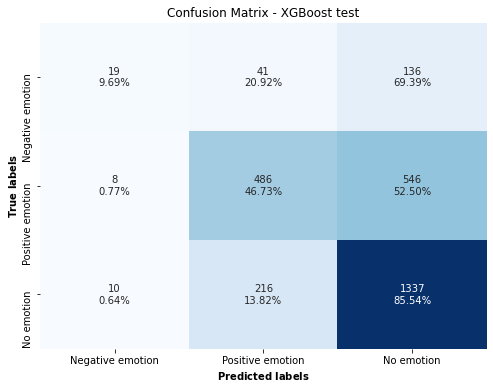

Weighted F1 Score: 0.63


In [28]:
plot_confusion_matrix_and_f1(y_test, y_pred_test_xgb, title='Confusion Matrix - XGBoost test')

We are going to check the level of overfitting in the XGBoost

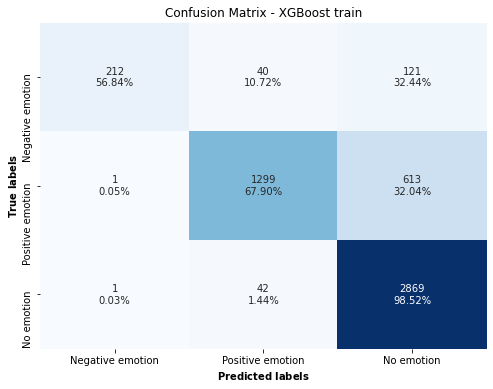

Weighted F1 Score: 0.84


In [29]:
# Let's do the predict of X_train
y_pred_train_xgb = xgb.predict(X_train)
plot_confusion_matrix_and_f1(y_train, y_pred_train_xgb, title='Confusion Matrix - XGBoost train')

As we can see the overfitting is high for XGBoost judging the F1-scores of the train and test datasets

We are now going to create another XGBoost model to try to reduce the overfitting

In [30]:
# Initializing the XGBClassifier
xgb_2 = XGBClassifier(random_state=12, max_depth=3, max_leaves=4)

# Let's do a fit on X_train and y_train
xgb_2.fit(X_train, y_train)

# Let's do the predict of X_test
y_pred_test_xgb_2 = xgb_2.predict(X_test)

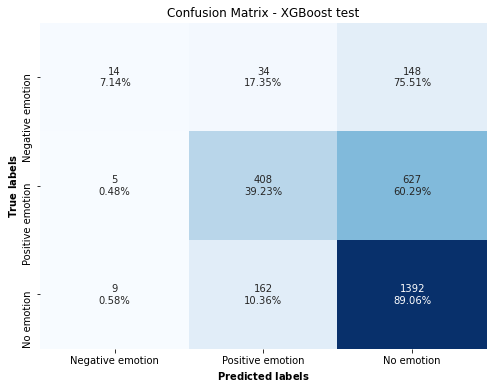

Weighted F1 Score: 0.61


In [31]:
plot_confusion_matrix_and_f1(y_test, y_pred_test_xgb_2, title='Confusion Matrix - XGBoost test')

Let's look at the overfitting now

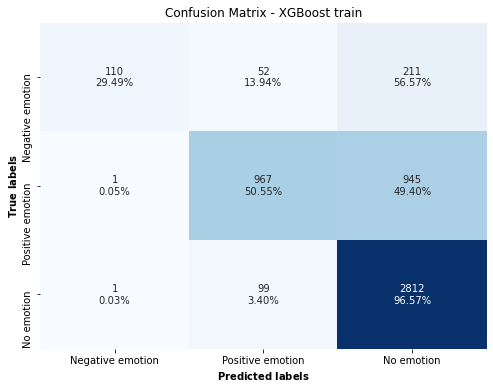

Weighted F1 Score: 0.73


In [32]:
# Let's do the predict of X_train
y_pred_train_xgb_2 = xgb_2.predict(X_train)
plot_confusion_matrix_and_f1(y_train, y_pred_train_xgb_2, title='Confusion Matrix - XGBoost train')

## 6.5 Choosing the model

After considering the different models that were run, we believe that neural networks is the most adequate for different reasons: it has one of the highest f1-scores, the overfitting is contained and the rate of correctly predicted labels are the highest.

We are now going to proceed to do the fine-tunning of the neural network model.

In [33]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Total number of models to try
    executions_per_trial=3,  # Number of times to train each model
    directory='tmp_nnr',  # Where to save the search results
    project_name='tuning_neural_network'
)

# Perform the search for optimal hyperparameters
tuner.search(X_train_np, y_train_np, epochs=7, validation_data=(X_test_np, y_test_np), batch_size=64)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first layer is {best_hps.get('units_1')} with a dropout of {best_hps.get('dropout_1')}.
The optimal number of units in the second layer is {best_hps.get('units_2')} with a dropout of {best_hps.get('dropout_2')}.
The optimal number of units in the third layer is {best_hps.get('units_3')} with a dropout of {best_hps.get('dropout_3')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_np, y_train_np, epochs=7, validation_data=(X_test_np, y_test_np), batch_size=64)

Reloading Tuner from tmp_nnr\tuning_neural_network\tuner0.json

The optimal number of units in the first layer is 160 with a dropout of 0.30000000000000004.
The optimal number of units in the second layer is 64 with a dropout of 0.4.
The optimal number of units in the third layer is 16 with a dropout of 0.4.
The optimal learning rate for the optimizer is 0.0017308008389249545.

Epoch 1/7
82/82 [==============================] - 1s 8ms/step - loss: 0.9300 - accuracy: 0.5431 - val_loss: 0.8380 - val_accuracy: 0.5584
Epoch 2/7
82/82 [==============================] - 1s 6ms/step - loss: 0.7945 - accuracy: 0.6143 - val_loss: 0.7814 - val_accuracy: 0.6395
Epoch 3/7
82/82 [==============================] - 0s 6ms/step - loss: 0.6312 - accuracy: 0.7347 - val_loss: 0.8129 - val_accuracy: 0.6442
Epoch 4/7
82/82 [==============================] - 0s 6ms/step - loss: 0.4523 - accuracy: 0.8255 - val_loss: 0.9559 - val_accuracy: 0.6395
Epoch 5/7
82/82 [==============================] - 0s 5ms/step 

In [34]:
# Make predictions
predictions_best_model = best_model.predict(X_test_np)

# Since the model outputs probabilities, we want to convert these to class labels
# Find the index of the maximum probability for each sample, which corresponds to the predicted class
predicted_classes_best_model = np.argmax(predictions_best_model, axis=1)

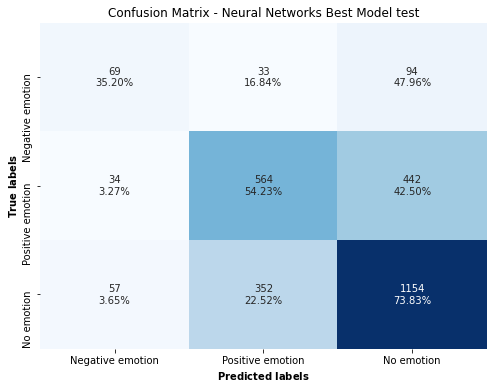

Weighted F1 Score: 0.63


In [35]:
plot_confusion_matrix_and_f1(y_test, predicted_classes_best_model, title='Confusion Matrix - Neural Networks Best Model test')

In [36]:
# Make predictions
predictions_best_model_train = best_model.predict(X_train_np)

# Since the model outputs probabilities, we want to convert these to class labels
# Find the index of the maximum probability for each sample, which corresponds to the predicted class
predicted_classes_best_model_train = np.argmax(predictions_best_model_train, axis=1)

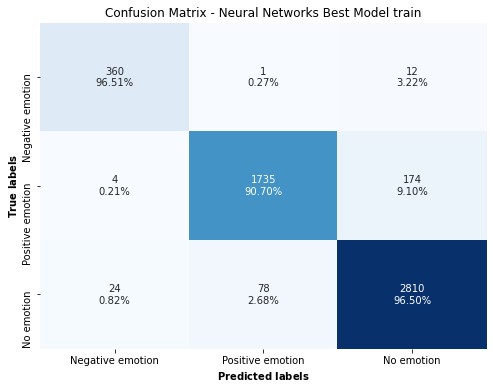

Weighted F1 Score: 0.94


In [37]:
plot_confusion_matrix_and_f1(y_train, predicted_classes_best_model_train, title='Confusion Matrix - Neural Networks Best Model train')

We will now try different alternatives to reduce the overfitting that is clearly visible when looking at the difference between F1-score of the train (0.94) and that of the test (0.63). Amongst them, we will try out early stopping, and the l1 and l2 regularizations. 

### 6.5.1 L2 regularization

In [38]:
# Instantiate the tuner
tuner_l2 = kt.RandomSearch(
    build_model_l2,  # Using the new function name here
    objective='val_accuracy',
    max_trials=20,  # Total number of models to try
    executions_per_trial=3,  # Number of times to train each model
    directory='tmp_nnr',  # Where to save the search results
    project_name='tuning_neural_network'
)

# Perform the search for optimal hyperparameters
tuner_l2.search(X_train_np, y_train_np, epochs=7, validation_data=(X_test_np, y_test_np), batch_size=64)

# Get the optimal hyperparameters
best_hps_l2 = tuner_l2.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first layer is {best_hps_l2.get('units_1')} with a dropout of {best_hps_l2.get('dropout_1')}.
The optimal number of units in the second layer is {best_hps_l2.get('units_2')} with a dropout of {best_hps_l2.get('dropout_2')}.
The optimal number of units in the third layer is {best_hps_l2.get('units_3')} with a dropout of {best_hps_l2.get('dropout_3')}.
The optimal learning rate for the optimizer is {best_hps_l2.get('learning_rate')}.
""")

# Build and train the best model
best_model_l2 = tuner_l2.hypermodel.build(best_hps_l2)
history_l2 = best_model_l2.fit(X_train_np, y_train_np, epochs=7, validation_data=(X_test_np, y_test_np), batch_size=64)

Reloading Tuner from tmp_nnr\tuning_neural_network\tuner0.json

The optimal number of units in the first layer is 160 with a dropout of 0.30000000000000004.
The optimal number of units in the second layer is 64 with a dropout of 0.4.
The optimal number of units in the third layer is 16 with a dropout of 0.4.
The optimal learning rate for the optimizer is 0.0017308008389249545.

Epoch 1/7
82/82 [==============================] - 1s 11ms/step - loss: 1.3084 - accuracy: 0.5210 - val_loss: 0.9471 - val_accuracy: 0.5584
Epoch 2/7
82/82 [==============================] - 1s 9ms/step - loss: 0.9489 - accuracy: 0.5552 - val_loss: 0.9054 - val_accuracy: 0.5584
Epoch 3/7
82/82 [==============================] - 1s 8ms/step - loss: 0.9265 - accuracy: 0.5579 - val_loss: 0.8966 - val_accuracy: 0.5584
Epoch 4/7
82/82 [==============================] - 1s 8ms/step - loss: 0.9094 - accuracy: 0.5602 - val_loss: 0.8961 - val_accuracy: 0.5584
Epoch 5/7
82/82 [==============================] - 1s 8ms/step

In [39]:
# Make predictions
predictions_best_model_l2 = best_model_l2.predict(X_test_np)

# Since the model outputs probabilities, we want to convert these to class labels
# Find the index of the maximum probability for each sample, which corresponds to the predicted class
predicted_classes_best_model_l2 = np.argmax(predictions_best_model_l2, axis=1)

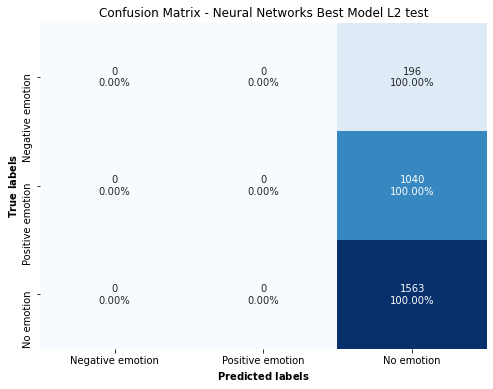

Weighted F1 Score: 0.40


In [40]:
plot_confusion_matrix_and_f1(y_test, predicted_classes_best_model_l2, title='Confusion Matrix - Neural Networks Best Model L2 test')

In [41]:
# Make predictions
predictions_best_model_train_l2 = best_model_l2.predict(X_train_np)

# Since the model outputs probabilities, we want to convert these to class labels
# Find the index of the maximum probability for each sample, which corresponds to the predicted class
predicted_classes_best_model_train_l2 = np.argmax(predictions_best_model_train_l2, axis=1)

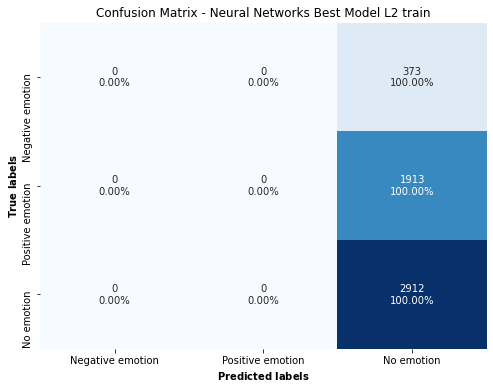

Weighted F1 Score: 0.40


In [42]:
plot_confusion_matrix_and_f1(y_train, predicted_classes_best_model_train_l2, title='Confusion Matrix - Neural Networks Best Model L2 train')

### 6.5.2 L1 Regularization

In [44]:
# Instantiate the tuner
tuner_l1 = kt.RandomSearch(
    build_model_l1,  # Using the new function name here
    objective='val_accuracy',
    max_trials=20,  # Total number of models to try
    executions_per_trial=3,  # Number of times to train each model
    directory='tmp_nnr',  # Where to save the search results
    project_name='tuning_neural_network'
)

# Perform the search for optimal hyperparameters
tuner_l1.search(X_train_np, y_train_np, epochs=7, validation_data=(X_test_np, y_test_np), batch_size=64)

# Get the optimal hyperparameters
best_hps_l1 = tuner_l1.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first layer is {best_hps_l1.get('units_1')} with a dropout of {best_hps_l1.get('dropout_1')}.
The optimal number of units in the second layer is {best_hps_l1.get('units_2')} with a dropout of {best_hps_l1.get('dropout_2')}.
The optimal number of units in the third layer is {best_hps_l1.get('units_3')} with a dropout of {best_hps_l1.get('dropout_3')}.
The optimal learning rate for the optimizer is {best_hps_l1.get('learning_rate')}.
""")

# Build and train the best model
best_model_l1 = tuner_l1.hypermodel.build(best_hps_l1)
history_l1 = best_model_l1.fit(X_train_np, y_train_np, epochs=7, validation_data=(X_test_np, y_test_np), batch_size=64)

Reloading Tuner from tmp_nnr\tuning_neural_network\tuner0.json

The optimal number of units in the first layer is 160 with a dropout of 0.30000000000000004.
The optimal number of units in the second layer is 64 with a dropout of 0.4.
The optimal number of units in the third layer is 16 with a dropout of 0.4.
The optimal learning rate for the optimizer is 0.0017308008389249545.

Epoch 1/7
82/82 [==============================] - 1s 10ms/step - loss: 12.0498 - accuracy: 0.5462 - val_loss: 2.2878 - val_accuracy: 0.5584
Epoch 2/7
82/82 [==============================] - 1s 8ms/step - loss: 2.0588 - accuracy: 0.5414 - val_loss: 1.9248 - val_accuracy: 0.5584
Epoch 3/7
82/82 [==============================] - 1s 8ms/step - loss: 1.9447 - accuracy: 0.5518 - val_loss: 1.9398 - val_accuracy: 0.5584
Epoch 4/7
82/82 [==============================] - 1s 8ms/step - loss: 1.9286 - accuracy: 0.5521 - val_loss: 1.8962 - val_accuracy: 0.5584
Epoch 5/7
82/82 [==============================] - 1s 8ms/ste

In [45]:
# Make predictions
predictions_best_model_l1 = best_model_l1.predict(X_test_np)

# Since the model outputs probabilities, we want to convert these to class labels
# Find the index of the maximum probability for each sample, which corresponds to the predicted class
predicted_classes_best_model_l1 = np.argmax(predictions_best_model_l1, axis=1)

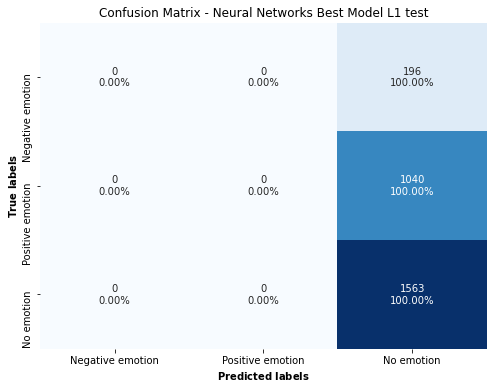

Weighted F1 Score: 0.40


In [46]:
plot_confusion_matrix_and_f1(y_test, predicted_classes_best_model_l1, title='Confusion Matrix - Neural Networks Best Model L1 test')

In [47]:
# Make predictions
predictions_best_model_train_l1 = best_model_l1.predict(X_train_np)

# Since the model outputs probabilities, we want to convert these to class labels
# Find the index of the maximum probability for each sample, which corresponds to the predicted class
predicted_classes_best_model_train_l1 = np.argmax(predictions_best_model_train_l1, axis=1)

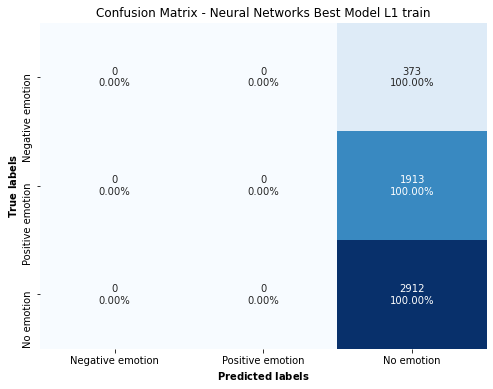

Weighted F1 Score: 0.40


In [48]:
plot_confusion_matrix_and_f1(y_train, predicted_classes_best_model_train_l1, title='Confusion Matrix - Neural Networks Best Model L1 train')

### 6.5.3 Early Stopping

In [49]:
# Instantiate the tuner
tuner_es = kt.RandomSearch(
    build_model_es,  # Using the new function name here
    objective='val_accuracy',
    max_trials=20,  # Total number of models to try
    executions_per_trial=3,  # Number of times to train each model
    directory='tmp_nnr',  # Where to save the search results
    project_name='tuning_neural_network'
)

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform the search for optimal hyperparameters with early stopping
tuner_es.search(X_train_np, y_train_np, epochs=100, validation_data=(X_test_np, y_test_np), batch_size=64, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps_es = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first layer is {best_hps_es.get('units_1')} with a dropout of {best_hps_es.get('dropout_1')}.
The optimal number of units in the second layer is {best_hps_es.get('units_2')} with a dropout of {best_hps_es.get('dropout_2')}.
The optimal number of units in the third layer is {best_hps_es.get('units_3')} with a dropout of {best_hps_es.get('dropout_3')}.
The optimal learning rate for the optimizer is {best_hps_es.get('learning_rate')}.
""")

# Build and train the best model with early stopping
best_model_es = tuner_es.hypermodel.build(best_hps_es)
history_es = best_model_es.fit(X_train_np, y_train_np, epochs=100, validation_data=(X_test_np, y_test_np), batch_size=64, callbacks=[early_stopping])

Reloading Tuner from tmp_nnr\tuning_neural_network\tuner0.json

The optimal number of units in the first layer is 160 with a dropout of 0.30000000000000004.
The optimal number of units in the second layer is 64 with a dropout of 0.4.
The optimal number of units in the third layer is 16 with a dropout of 0.4.
The optimal learning rate for the optimizer is 0.0017308008389249545.

Epoch 1/100
82/82 [==============================] - 1s 8ms/step - loss: 0.9233 - accuracy: 0.5425 - val_loss: 0.8319 - val_accuracy: 0.5584
Epoch 2/100
82/82 [==============================] - 0s 5ms/step - loss: 0.7817 - accuracy: 0.6158 - val_loss: 0.7965 - val_accuracy: 0.6338
Epoch 3/100
82/82 [==============================] - 0s 6ms/step - loss: 0.6090 - accuracy: 0.7495 - val_loss: 0.8522 - val_accuracy: 0.6402
Epoch 4/100
82/82 [==============================] - 0s 5ms/step - loss: 0.4572 - accuracy: 0.8232 - val_loss: 0.8966 - val_accuracy: 0.6288
Epoch 5/100
82/82 [==============================] - 0s

In [50]:
# Make predictions
predictions_best_model_es = best_model_es.predict(X_test_np)

# Since the model outputs probabilities, we want to convert these to class labels
# Find the index of the maximum probability for each sample, which corresponds to the predicted class
predicted_classes_best_model_es = np.argmax(predictions_best_model_es, axis=1)

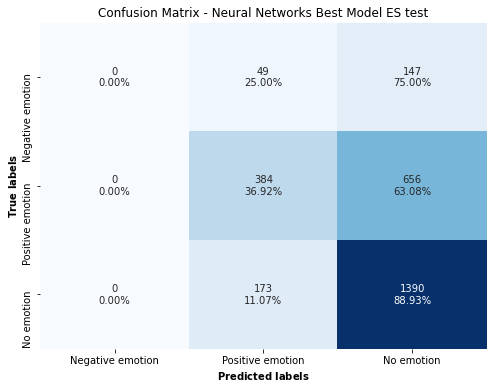

Weighted F1 Score: 0.59


In [51]:
plot_confusion_matrix_and_f1(y_test, predicted_classes_best_model_es, title='Confusion Matrix - Neural Networks Best Model ES test')

In [52]:
# Make predictions
predictions_best_model_train_es = best_model_es.predict(X_train_np)

# Since the model outputs probabilities, we want to convert these to class labels
# Find the index of the maximum probability for each sample, which corresponds to the predicted class
predicted_classes_best_model_train_es = np.argmax(predictions_best_model_train_es, axis=1)

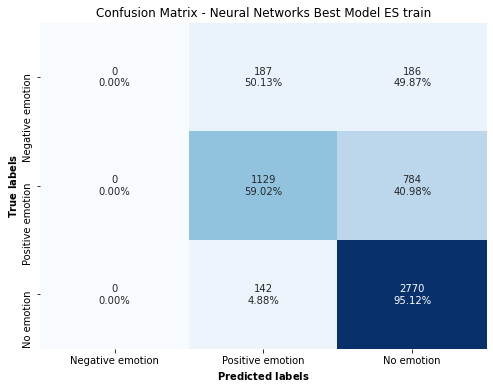

Weighted F1 Score: 0.71


In [53]:
plot_confusion_matrix_and_f1(y_train, predicted_classes_best_model_train_es, title='Confusion Matrix - Neural Networks Best Model ES train')

## 6.6 Save the Model

In [54]:
best_model.save('pickle_objects/neural_network.h5')

# 7. Conclusion

In the coorporate world, the model wouldn't be convincing because the results are very poor. However, because we are in an academic level and because we have tried different options to improve the metrics and the results of the model, we consider it to be a good project and we have consolidated the base of a data science project creation. 

We clearly loose a lot in the negative emotions which affects our capacity to make decisions, however the model does have a good prediction rate of the tweets that have no emotion and positive emotions as can be seen in the confusion matrix. 
This all means, that when we give predictions, if they are in favor of a positive emotion, we are going to support the technological company with the different banners we will provide in our webpage. 

Moreover, there is clear overfitting. We have tried to mitigate it using different techniques but it hasn't been possible to mitigate it more than is shared above. Again, given that we are in an academic situation, we continue with this model because it is the one that gives us the best results. But if we were in a professional environment, we would have to discard the project or increase the size of the dataset to reduce the overfitting.

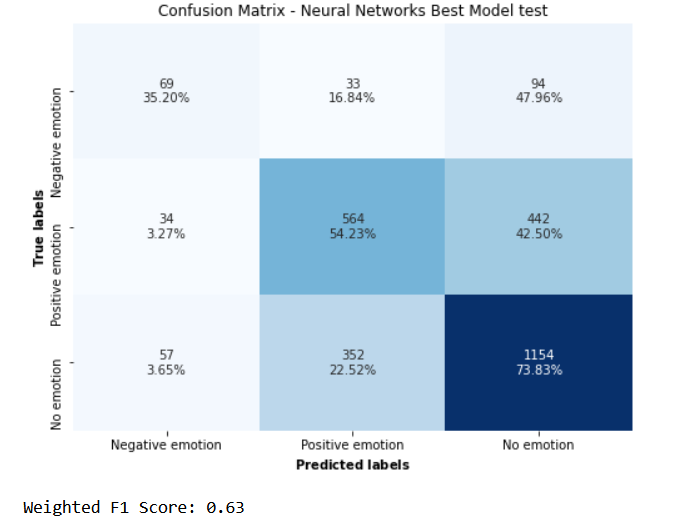